# RNN for advance ratio based localization example

3 Cell towers

## Inputs
1. Timestep between timestep 0 and timestep 1
2. Cell_0 Advance ratio change for timestep 0 (if this cells advance ratio is measured)
3. Cell_1 Advance ratio change for timestep 0 (if this cells advance ratio is measured)
4. Cell_2 Advance ratio change for timestep 0 (if this cells advance ratio is measured)

Each actual input includes just one advance ratio measurement so only one change is known.  Others will be set to zero so they do not contribute to the next hidden state or output.

## Outputs
1. Cell_0 Advance ratio change for timestep 1
2. Cell_1 Advance ratio change for timestep 1
3. Cell_2 Advance ratio change for timestep 1

RNN should predict advance ratio for each cell regardless of which cell generated the timing advance causing the step.

## Loss
Regression MSE of difference between timing advance difference predicted and measured for a cell.  

## Example
E.g cell_1 produces measurements 16, 8, and 32 at time 0, 0.1 and 0.5.  This gives a ta difference of -8 and +24 and a time difference of 0.1 and 0.4.  Assuming that the RNN then predicts 10.

There for the input without normalization will be

t0  | t1
Inputs
0.1 | 0.4
-8  | 24  

RNN Outputs
t0   | t1
X    | 10 

Then the MSE is 

(24 - 8) ^2 = 256


In [178]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.rnn import BasicRNNCell
from tensorflow.contrib.rnn import BasicLSTMCell
import sklearn.preprocessing
import matplotlib
import matplotlib.pyplot as plt
import time
import logging
from IPython import display
from functools import reduce
from math import isclose
import random
import functools
import multiprocessing

print("Tensorflow version: {}".format(tf.__version__))

# Hyperparameters
learning_rate = 1e-2
hidden_neurons = 128

seq_len_split = 200
seq_max_len = seq_len_split
batch_size = 1024

epochs = 100

input_count = cell_count * 2 + 1
train_validation_test_split = [0.7, 0.2, 0.1]

if not isclose(reduce(lambda x,y: x + y, train_validation_test_split), 1.0, rel_tol=1e-06, abs_tol=1e-06):
    raise ValueError("Sum of train, validation, test split must be 1.  We only have so much data!")

cell_measurement_strategy = ("random")
valid_cell_measurement_strategies = ("random", "nearest")
if not cell_measurement_strategy in valid_cell_measurement_strategies:
    raise ValueError("Cell measurement strategy not valid!")
path_count = 10
ta_count = 201 
test_path_count = 10
test_ta_count = 10
# Cell positions for ta measurements.
cell_pos = np.array([[0.3, 0.8], [0.8, 0.6], [0.4, 0.1]])
cell_count = 3
if not cell_count == cell_pos.shape[0]:
    raise ValueError("cell_count does not match number of positions in cell_pos")

np.set_printoptions(precision=3)
%matplotlib inline  

Tensorflow version: 1.1.0


# Helper Functions

In [95]:
def gen_data(path_count, ta_count):
    # Generate points defining direction change on path.
    path_points = np.random.rand(path_count + 1, 2)
    # Generate times for direction change.
    path_time = np.random.rand(path_count)
    path_time = np.cumsum(path_time / np.sum(path_time))
    path_time = np.concatenate((np.zeros(1), path_time))
    # Generate times for ta measurement.
    ta_time = np.random.rand(ta_count)
    ta_time = np.cumsum(ta_time / np.sum(ta_time))
    return (path_points, path_time, ta_time)

In [96]:
def get_ta_points(ta_time, path_time, path_points):
    """
    Returns points on paths for timing advance measurements
    """
    # Assign ta measurements to paths based on time.
    ta_path_lookup = [int(np.digitize(x, path_time)) for x in ta_time]
    ta_points = []
    for i, x in enumerate(ta_time):
        idx = ta_path_lookup[i]
        if idx > path_time.size - 1:
            idx = path_time.size - 1
        total_dist_diff = path_points[idx] - path_points[idx - 1]
        if idx > 0:
            total_time_diff = path_time[idx] - path_time[idx - 1]
        else:
            total_time_diff = path_time[idx]
        ta_time_diff = path_time[idx] - x
        time_prop_diff = 1.0 - ta_time_diff / total_time_diff
        ta_point = path_points[idx - 1] + time_prop_diff * total_dist_diff
        ta_points.append(ta_point)
    return np.array(ta_points)

In [97]:
def ta_cell_measurement(ta_points, single_cell_pos):
    cell_dist_xy = ta_points - single_cell_pos[0,:]
    cell_dist = np.sqrt(np.power(cell_dist_xy[:, 0], 2) + np.power(cell_dist_xy[:, 1], 2))
    return cell_dist
def ta_measurements(ta_points, cell_pos):
    cell_count = cell_pos.shape[0]
    cell_pos_split = np.split(cell_pos, cell_count, axis=0)
    cell_ta_measurements = np.array(list(map(lambda x: ta_cell_measurement(ta_points, x), cell_pos_split)))
    return np.swapaxes(cell_ta_measurements, 0, 1)

In [98]:
def plot_map(cell_pos, path_points, ta_points, ta_circles):
    fig, ax = plt.subplots()
    ax.scatter(cell_pos[:,0], cell_pos[:,1])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title("Cell Locations")
    ax.plot(path_points[:,0], path_points[:,1], color="green")
    ax.scatter(ta_points[:,0], ta_points[:,1])
    for circle in ta_circles:
        ax.add_artist(circle)

In [99]:
def plot_map_slow(cell_pos, path_points, ta_points, ta_circles, sleep_time):
    for i in range(len(ta_points)):
        fig, ax = plt.subplots()
        ax.scatter(cell_pos[:,0], cell_pos[:,1])
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_title("Cell Locations")
        ax.plot(path_points[:,0], path_points[:,1], color="green")
        ax.scatter(ta_points[i,0], ta_points[i,1])
        ta_circles_0, ta_circles_1, ta_circles_2 = zip(*ta_circles)
        time.sleep(sleep_time)
        ax.add_artist(ta_circles_0[i])
        ax.add_artist(ta_circles_1[i])
        ax.add_artist(ta_circles_2[i])
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [100]:
def build_sample(ta_meas):
    
    cell_selection = np.random.randint(0, cell_count, ta_meas.shape[0])
    #return np.take(ta_meas, cell_selection) 
    cell_selection_extra_dim = np.reshape(cell_selection, (ta_meas.shape[0],1))
    #return ta_meas[:, cell_selection]
    ta_meas_selection = np.concatenate((ta_meas, cell_selection_extra_dim), axis=1)
    return (cell_selection, np.apply_along_axis(lambda x: x[int(x[cell_count])], 1, ta_meas_selection))
    #return np.apply_along_axis(lambda x, y: x[y], 1, ta_meas, cell_selection)

In [101]:
def calc_diff_with_time(ta_meas, ta_time, cell_selection):
    return list(map(lambda x: (np.diff(ta_meas[cell_selection == x, x]), 
                    np.diff(ta_time[cell_selection == x]), x), 
                    np.arange(cell_count)))

In [102]:
def run_iteration(sess, model, x, initial_state, train=False):
    total_loss_batch = []
    outputs_batch = []
    train_model_op = model.train_step if train else model.no_op
    for batch_no in range(len(x)):
        outputs, total_loss, _ = sess.run(
                        [model.outputs, model.total_loss, 
                         train_model_op],
                         feed_dict={
                            model.x: x[batch_no],
                            model.seq_len: np.full(batch_size, seq_len_split),
                            model.initial_state: initial_state
                        })
        total_loss_batch.append(total_loss)
        outputs_batch.append(outputs)
    return (total_loss_batch, outputs_batch)

In [119]:
def build_input(ta_meas, ta_time, cell_selection_one_hot):
    arr = ta_meas * cell_selection_one_hot
    
     # If first element is zero replace by first nonzero value
    for i in range(cell_count):
        nonzero_ele = np.nonzero(arr[:,i])[0]
        if len(nonzero_ele) > 0:
            arr[0, i] =  arr[:, i][nonzero_ele[0]]
    prev = np.arange(len(arr), cell_count)
    prev = np.mgrid[0:len(arr - 1), 0:cell_count][0]
    prev[arr==0]=0
    prev = np.maximum.accumulate(prev, axis=0)
    for i in range(cell_count):
        arr[:, i] = arr[prev[:,i], i]
    ta_meas_diff = np.diff(arr, axis=0)
    ta_meas_cell_selection = np.concatenate((ta_meas_diff, cell_selection_one_hot[1:]), axis=1)
    sample_input = np.concatenate((ta_meas_cell_selection, 
                                   np.reshape(np.concatenate((
                                                              np.diff(ta_time)[1:],
                                                              np.zeros(1)
                                                              )), 
                                                              (ta_time.shape[0] - 1, 1))), axis=1)
    return sample_input

In [104]:
def fill_zero_with_rep(arr):
    prev = np.arange(len(arr))
    prev[arr==0]=0
    prev = np.maximum.accumulate(prev)
    return arr[prev]

In [105]:
def fill_zero_with_rep(arr):
    # If first element is zero replace by first nonzero value
    for i in range(cell_count):
        nonzero_ele = np.nonzero(arr[:,i])[0]
        if len(nonzero_ele) > 0:
            arr[0, i] =  arr[:, i][nonzero_ele[0]]
    prev = np.arange(len(arr), cell_count)
    prev = np.mgrid[0:len(arr - 1), 0:cell_count][0]
    prev[arr==0]=0
    prev = np.maximum.accumulate(prev, axis=0)
    for i in range(cell_count):
        arr[:, i] = arr[prev[:,i], i] 
    return arr

In [106]:
def build_batch(batch_size):
    sample_input_list = []
    for i in range(batch_size):
        path_points, path_time, ta_time = gen_data(path_count, ta_count)
        ta_points = get_ta_points(ta_time, path_time, path_points)
        ta_meas = ta_measurements(ta_points, cell_pos)
        cell_selection, reduced_meas = build_sample(ta_meas)
        cell_selection_one_hot = np.eye(ta_count, cell_count)[cell_selection]
        sample_input_list.append(np.expand_dims(build_input(ta_meas, ta_time, cell_selection_one_hot), axis=0))
    return functools.reduce(lambda x, y: np.concatenate((x, y), axis=0), sample_input_list)

In [107]:
def build_batch_mp(queue):
    sample_input_list = []
    for i in range(batch_size):
        path_points, path_time, ta_time = gen_data(path_count, ta_count)
        ta_points = get_ta_points(ta_time, path_time, path_points)
        ta_meas = ta_measurements(ta_points, cell_pos)
        cell_selection, reduced_meas = build_sample(ta_meas)
        cell_selection_one_hot = np.eye(ta_count, cell_count)[cell_selection]
        sample_input_list.append(np.expand_dims(build_input(ta_meas, ta_time, cell_selection_one_hot), axis=0))
    queue.put(functools.reduce(lambda x, y: np.concatenate((x, y), axis=0), sample_input_list))

In [171]:
def run_batch(sess, model, x, initial_state, batch_size, train=False, extra_iterations=1,seq_len=seq_max_len):
    # Add padding if needed
    padding = np.zeros((x.shape[0], seq_max_len - seq_len, x.shape[2]))
    x = np.concatenate((x, padding), axis=1)
    for i in range(extra_iterations):
        train_model_op = model.train_step if train else model.no_op
        outputs, total_loss, _ = sess.run(
                        [model.outputs, model.total_loss, 
                         train_model_op],
                         feed_dict={
                            model.x: x,
                            model.seq_len: np.full(batch_size, seq_len),
                            model.initial_state: initial_state
                        })
    return (total_loss[:seq_len], outputs[])


# Generate example data

In [109]:
path_points, path_time, ta_time = gen_data(path_count, ta_count)
ta_points = get_ta_points(ta_time, path_time, path_points)
ta_meas = ta_measurements(ta_points, cell_pos)

In [110]:
cell_selection, reduced_meas = build_sample(ta_meas)
cell_selection_one_hot = np.eye(ta_count, cell_count)[cell_selection]

In [111]:
ta_circles = list(map(lambda x, y: plt.Circle((cell_pos[y, 0], cell_pos[y, 1]), x
                  ,facecolor="none", edgecolor="black"), 
                  np.split(reduced_meas, reduced_meas.shape[0]), np.split(cell_selection, cell_selection.shape[0])))

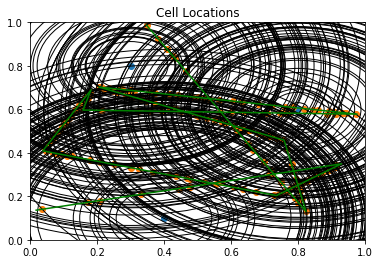

In [112]:
plot_map(cell_pos, path_points, ta_points, ta_circles)

# RNN Model

In [113]:
class PredictTA(object):
    def __init__(self, hidden_neurons, seq_max_len):
        tf.reset_default_graph()
        # Tensorflow placeholders
        self.x = tf.placeholder(tf.float32, [None, seq_max_len, input_count], name="x")
        self.seq_len = tf.placeholder(tf.int32, [None], name="seq_len")
        self.initial_state = tf.placeholder(tf.float32 , [None, hidden_neurons], name="initial_state")
        # Tensorflow weights and biases
        self._weights, self._bias = {}, {}
        # Output layer parameters
        self._weights["h_o"] = tf.Variable(tf.random_uniform([hidden_neurons, cell_count], 
                                                             -0.1, 0.1),dtype=tf.float32, 
                                                             name="w_h_o")
        self._bias["o"] = tf.Variable(tf.random_uniform([cell_count], -0.1, 0.1), dtype=tf.float32, name="b_o")
        cell = BasicRNNCell(hidden_neurons)
        states, current_state = tf.nn.dynamic_rnn(cell, 
                                                  self.x, 
                                                  initial_state=self.initial_state, 
                                                  sequence_length=self.seq_len - 1)
        states_series = tf.unstack(states, axis=1)
        logits_series = [tf.add(tf.matmul(state, self._weights["h_o"]), self._bias["o"]) 
                                  for state in states_series]
        y_series = tf.unstack(self.x[:,:,:cell_count], axis=1)[1:]
        logits_labels = zip(logits_series, y_series)
        self.outputs = logits_series
        losses = [(tf.losses.mean_squared_error(predictions=logits, labels=labels)) 
                  for logits, labels in logits_labels]
        self.total_loss = tf.reduce_mean(losses)
        self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.total_loss)
        self.no_op = tf.no_op()

In [114]:
model = PredictTA(hidden_neurons=hidden_neurons, seq_max_len=seq_max_len)

In [115]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train Model

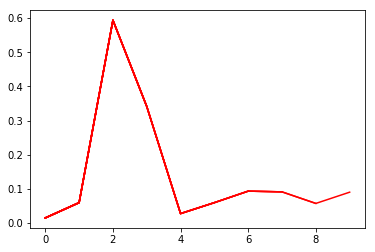

In [116]:
total_loss_list = []
queue = multiprocessing.Queue()
p = multiprocessing.Process(target=build_batch_mp, args=(queue,))
p.start()
for i in range(10):
    start = time.clock() 
    x = queue.get() 
    p.join()
    p = multiprocessing.Process(target=build_batch_mp, args=(queue,))
    p.start()
    init_state = np.zeros([batch_size, hidden_neurons])
    total_loss, outputs = run_batch(sess, model, x, init_state, batch_size=batch_size, train=True, extra_iterations=1)
    total_loss_list.append(total_loss)
    plt.plot(total_loss_list, "red")
    print ("Time spent per iteration is : {}".format( time.clock() - start ))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Test Model

In [ ]:
test_

In [181]:
path_points, path_time, ta_time = gen_data(test_path_count, test_ta_count)
ta_points = get_ta_points(ta_time, path_time, path_points)
ta_meas = ta_measurements(ta_points, cell_pos)

In [182]:
ta_points = get_ta_points(ta_time, path_time, path_points)
ta_meas = ta_measurements(ta_points, cell_pos)
cell_selection, reduced_meas = build_sample(ta_meas)
cell_selection_one_hot = np.eye(ta_count, cell_count)[cell_selection]
x = np.expand_dims(build_input(ta_meas, ta_time, cell_selection_one_hot), axis=0)
init_state = np.zeros([1, hidden_neurons])

In [183]:
total_loss, outputs = run_batch(sess, model, x, init_state, batch_size=1, train=True, extra_iterations=1, seq_len=10)
np_outputs = np.array(outputs)[:, 0, :]

In [184]:
np_outputs_cell_0 = np_outputs[:,0]
np_outputs_cell_1 = np_outputs[:,1]
np_outputs_cell_2 = np_outputs[:,2]
cell_selection_one_hot_0 = cell_selection_one_hot[:,0]
cell_selection_one_hot_1 = cell_selection_one_hot[:,1]
cell_selection_one_hot_2 = cell_selection_one_hot[:,2]

In [187]:
np_outputs.shape

(200, 3)

In [185]:
predictions = np.zeros((seq_max_len + 1, cell_count))
for cell in range(cell_count):
    idx = 0
    for pred_delta in np.nditer(np_outputs[:, cell]):
        # If measured cell then update with true value otherwise we have to accumulate predicted deltas.
        if cell_selection[idx] == cell:
            predictions[idx + 1, cell] = ta_meas[idx, cell] + pred_delta
        else:
            predictions[idx + 1, cell] = predictions[idx, cell] + pred_delta
        idx += 1
         

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
ta_meas * cell_selection_one_hot

In [ ]:
ta_circles_0 = list(map(lambda x: plt.Circle((cell_pos[0, 0], cell_pos[0, 1]), x
                  ,facecolor="none", edgecolor="black"), 
                  predictions[:,0]))
ta_circles_1 = list(map(lambda x: plt.Circle((cell_pos[1, 0], cell_pos[1, 1]), x
                  ,facecolor="none", edgecolor="black"), 
                  predictions[:,1]))
ta_circles_2 = list(map(lambda x: plt.Circle((cell_pos[2, 0], cell_pos[2, 1]), x
                  ,facecolor="none", edgecolor="black"), 
                  predictions[:,1]))
ta_circles = list(zip(ta_circles_0, ta_circles_1, ta_circles_2))

In [ ]:
ta_circles

In [ ]:
plot_map_slow(cell_pos, path_points, ta_points, ta_circles, sleep_time=0.5)